In [15]:
# file: graph_builder.py
from dotenv import load_dotenv
import os
load_dotenv()
from langtrace_python_sdk import langtrace # Must precede any llm module imports
langtrace.init(api_key = os.environ['LANGTRACE_API_KEY'])
import logging
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from state import AmelaReactCompatibleAgentState
from IPython.display import Image, display
from nodes import (
    query_analysis_node,
    route_after_qpa,
    direct_response_node,
    clarification_node,
    main_assistant_node,
    error_handler_node
)
 # Tải biến môi trường từ file .env nếu có

logger = logging.getLogger(__name__) # Đảm bảo logger được cấu hình nếu chạy file này độc lập

# --- Cấu hình Logging (nếu chưa có ở global) ---
if not logging.getLogger().handlers: # Chỉ cấu hình nếu chưa có handler nào
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

def build_graph():
    logger.info("--- Bắt đầu xây dựng Graph ---")
    workflow = StateGraph(AmelaReactCompatibleAgentState)

    logger.info("Thêm các nodes vào graph...")
    workflow.add_node("query_analyzer", query_analysis_node)
    workflow.add_node("direct_responder", direct_response_node)
    workflow.add_node("clarification_generator", clarification_node)
    workflow.add_node("main_assistant", main_assistant_node)
    workflow.add_node("error_handler", error_handler_node)

    workflow.set_entry_point("query_analyzer")
    logger.info("Đặt entry point là 'query_analyzer'.")

    # Sửa lỗi TypeError: start_key không còn được sử dụng
    workflow.add_conditional_edges(
        "query_analyzer",           # Node nguồn
        route_after_qpa,            # Hàm điều kiện (router)
        {                           # Mapping
            "direct_response_node": "direct_responder",
            "clarification_node": "clarification_generator",
            "main_assistant_node": "main_assistant",
            "error_handler": "error_handler"
        }
    )
    logger.info("Thêm conditional edges từ 'query_analyzer' dựa trên 'route_after_qpa'.")

    workflow.add_edge("direct_responder", END)
    workflow.add_edge("clarification_generator", END)
    workflow.add_edge("main_assistant", END)
    workflow.add_edge("error_handler", END)
    logger.info("Thêm edges đến END cho 'direct_responder', 'clarification_generator', 'main_assistant', 'error_handler'.")

    # memory = SqliteSaver.from_conn_string(":memory:")
    # Lưu vào file để có thể kiểm tra session state sau này nếu cần
    checkpointer = InMemorySaver() # SỬ DỤNG IN MEMORY SAVER
    logger.info("Sử dụng InMemorySaver để test.")

    app = workflow.compile(checkpointer=checkpointer)
    # Show workflow
    display(Image(app.get_graph().draw_mermaid_png()))
    logger.info("--- Graph đã được biên dịch thành công (với InMemorySaver) ---")
    return app

Initializing Langtrace SDK..
⭐ Leave our github a star to stay on top of our updates - https://github.com/Scale3-Labs/langtrace
Exporting spans to Amber chatbot..
Langtrace Project URL: https://app.langtrace.ai/project/cmavzqmxh000p141syh4wzzk8/traces


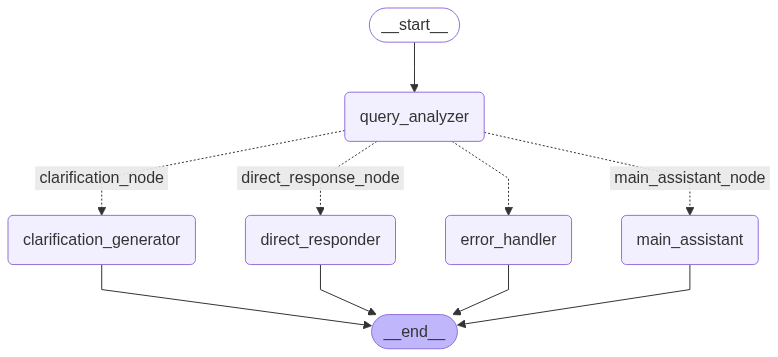

In [16]:
graph = build_graph()

In [17]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage